# **0. 참고자료**
## **0-1. 도서**
## **0-2. 논문, 학술지**
## **0-3. 웹 사이트**
- [바람돌이의 빅데이터] : [바람돌이/딥러닝] GCN 논문 리뷰 및 코드 리뷰 (Semi-Supervised Classification with Graph Convolutional Networks) | [[블로그 링크]](https://m.blog.naver.com/winddori2002/222183504185)

- pytorch-geometric : COLAB NOTEBOOKS AND VIDEO TUTORIALS - 2. Node Classification with Graph Neural Networks | [[코랩 링크]](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing)

- 아기여우의 자기계발 블로그 : Graph Neural Networks (GNN) / 그래프 뉴럴 네트워크 기초 개념 정리 | [[블로그 링크]](https://littlefoxdiary.tistory.com/16)


- Seongsu : 예제를 통해 알아보는 PyTorch Geometric 5 Basic Concepts | [[블로그 링크]](https://baeseongsu.github.io/posts/pytorch-geometric-introduction/)

## **0-4. 데이터셋 출처**
- tkipf github : pygcn | [[깃헙 링크]](https://github.com/tkipf/pygcn/tree/master/data/cora)

# **1. GNN (Graph Neural Network)란**
## **1-1. GNN을 알기 전에 Graph란**
- 그래프(Graph)는 노드와 간선으로 이루어진 구조  
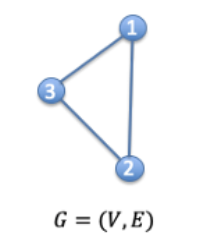

- 수학적으로 그래프 G는 노드 집합 V와 간선 집합 E로 구성된다.
  - 간선 집합 E의 원소 간선 e는 두 개의 노드로 이루어진 순서가 있는 쌍이다.
  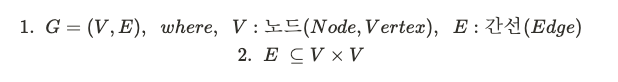


## **1-2. torch로 먼저 구현해보자**
- 이번 주제에서는 Cora 데이터 셋을 이용하였다.
  - Cora 데이터 셋에서 노드가 머신러닝 논문을 나타내고, 간선이 논문 간의 인용 여부를 나타내는 인용 그래프이다.
  - Cora 데이터 셋을 이용한 최종 목적은 각 논문을 7가지 범주 중 하나로 분류하는 것이다.
  - 주로 Semi-supervised graph node classification을 위한 데이터 셋으로 사용된다.

In [1]:
!cp -r "drive/MyDrive/Colab Notebooks/dataset/GCN/cora" cora

### **1) 데이터 셋부터 불러와 전처리하고 필요한 함수를 정의해보자**

In [2]:
import scipy.sparse as sp
import networkx as nx
import numpy as np
import pickle
import torch
import os

In [3]:
class Utils:

  ## 데이터 불러오는 함수
  def load_data(path='./cora/', dataset = 'cora'):

    print(f'Loading {dataset} dataset..')
    idx_feat_lb = np.genfromtxt(f'{path}{dataset}.content', dtype = np.dtype(str))

    ## cora.content에 있는 데이터 구조는 [인덱스, 피쳐 벡터, 레이블]로 구성되어 있다.
    feats  = sp.csr_matrix(idx_feat_lb[:, 1: -1], dtype=np.float32)

    ## 레이블 데이터 원 핫 인코딩 시키기
    labels = Utils.encode_onehot(idx_feat_lb[:, -1])

    ## graph 구성하기
    idx     = np.array(idx_feat_lb[:, 0], dtype = np.int32)
    idx_map = {j : i for i, j in enumerate(idx)} 

    unordered_edges = np.genfromtxt(f'{path}{dataset}.cites', dtype = np.int32)
    edges = np.array(list(map(idx_map.get, unordered_edges.flatten())), 
                     dtype = np.int32).reshape(unordered_edges.shape)

    ## 인접행렬 정의
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), 
                        shape = (labels.shape[0], labels.shape[0]), dtype = np.float32)
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    feats = Utils.normalize(feats)
    adj   = Utils.normalize(adj + sp.eye(adj.shape[0]))

    ## 학습 데이터를 따로 분할하는 것이 아니라 전체 데이터에서 인덱스 값으로 잘라서 사용
    train_idx = torch.LongTensor(range(140))
    val_idx   = torch.LongTensor(range(200, 500))
    test_idx  = torch.LongTensor(range(500, 1500))

    feats   = torch.FloatTensor(np.array(feats.todense()))
    labels  = torch.LongTensor(np.where(labels)[1])
    adj     = Utils.sparse_mx_to_torch_sparse_tensor(adj)

    return adj, feats, labels, train_idx, val_idx, test_idx

  
  ## 레이블을 원 핫 인코딩 시켜주는 함수
  def encode_onehot(labels):

    classes = set(labels)
    
    classes_dict  = {class_ : np.identity(len(classes))[idx, : ] for idx, class_ in enumerate(classes)} 
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype = np.int32)

    return labels_onehot


  ## sparse matrix의 열을 정규화 시켜주는 함수
  def normalize(mx):

    rowsum = np.array(mx.sum(1))
    r_inv  = np.power(rowsum, -1).flatten()
    
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)

    mx = r_mat_inv.dot(mx)
    return mx

  ## 정확도 계산해주는 함수
  def accuracy(output, labels):
    
    preds   = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()

    return correct /  len(labels)

  
  ## scipy sparse matrix를 sparse tensor로 변환해주는 함수
  def sparse_mx_to_torch_sparse_tensor(sparse_mx):

    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices   = torch.from_numpy(
                      np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64)
                    )
    values    = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)

    return torch.sparse.FloatTensor(indices, values, shape)

### **2) 레이어와 설계구조를 정의해보자**
- 참고한 github에서 논문의 Simple GCN과 비슷하게 구현했다고 한다.
- simple GCN이라고 해도 GNN 태스크가 굉장히 어려워서 복잡할 줄 알았는데, 생각보다 간단해서 놀랐다.

In [4]:
from torch.nn.modules.module import Module
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.nn as nn
import torch
import math

In [5]:
## Graph Convolution 레이어 구성
class GraphConv(Module):

  def __init__(self, in_feats, out_feats, bias = True):
    super(GraphConv, self).__init__()

    self.in_feats, self.out_feats = in_feats, out_feats
    self.weight = Parameter(torch.FloatTensor(in_feats, out_feats))
    self.fc     = nn.Linear(in_feats, out_feats)

    if bias: self.bias = Parameter(torch.FloatTensor(out_feats))
    else: self.register_param('bias', None)
    
    self.reset_params()


  def reset_params(self):
    stdv = 1. / math.sqrt(self.weight.size(1))
    self.weight.data.uniform_(-stdv, stdv)

    if self.bias is not None: self.bias.data.uniform_(-stdv, stdv)

  
  def forward(self, input, adj):
    support = torch.mm(input, self.weight)
    output  = torch.spmm(adj, support)

    if self.bias is not None: return output + self.bias
    else: return output


  def __repr__(self):
    return self.__class___.__name__ + '(' \
          + str(self.in_feats) + '->' + str(self.out_feats) + ')'


class GCN(Module):

  def __init__(self, n_feat, n_hid, n_class, dropout):

    super(GCN, self).__init__()

    self.gc1 = GraphConv(n_feat, n_hid)
    self.gc2 = GraphConv(n_hid, n_class)
    self.dropout = dropout


  def forward(self, x, adj):
    
    x = F.relu(self.gc1(x, adj))
    x = F.dropout(x, self.dropout, training = self.training)
    x = self.gc2(x, adj)

    return F.log_softmax(x, dim = 1)

### **3) 학습을 돌려보자**


In [6]:
import torch.optim as optim
import numpy as np
import time

In [7]:
LR           = 5e-3
EPOCHS       = 1000
HIDDEN       = 16
DROP_OUT     = 0.3
WEIGHT_DECAY = 5e-4

In [8]:
cuda   = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(cuda)

torch.manual_seed(99)
if cuda == 'cuda': torch.cuda.manual_seed(99)

In [9]:
## 데이터를 불러와보자
adj, feats, labels, train_idx, val_idx, test_idx = Utils.load_data()
model = GCN(
              n_feat  = feats.shape[1], n_hid = HIDDEN,
              n_class = labels.max().item() + 1, dropout = DROP_OUT 
            )

optimizer = optim.Adam(model.parameters(), lr = LR, weight_decay = 0.0 if WEIGHT_DECAY ==  None else WEIGHT_DECAY)
loss_func = F.nll_loss

Loading cora dataset..


In [10]:
if cuda == 'cuda':
  model.cuda()
  feats  = feats.cuda()
  adj    = adj.cuda()
  labels = labels.cuda()
  
  train_idx = train_idx.cuda()
  val_idx   = val_idx.cuda()
  test_idx  = test_idx.cuda()

In [11]:
def train(epoch):

  start_time = time.time()
  model.train()
  optimizer.zero_grad()

  output     = model(feats, adj)
  train_loss = loss_func(output[train_idx], labels[train_idx])
  train_acc  = Utils.accuracy(output[train_idx], labels[train_idx])
  
  train_loss.backward()
  optimizer.step() 

  val_loss = loss_func(output[val_idx], labels[val_idx])
  val_acc  = Utils.accuracy(output[val_idx], labels[val_idx])

  if epoch % 10 == 0:
    print(f'[Epoch: {epoch + 1} / {EPOCHS}]\n',
          f'train loss : {train_loss.item():.3f} | train accuracy : {train_acc.item():.3f}\n',
          f'valid loss : {val_loss.item():.3f} | valid accuracy: {val_acc.item():.3f}\n',
          f'time: {time.time() - start_time:.4f}s \n')

In [12]:
def test():
    model.eval()
    output = model(feats, adj)
    test_loss = loss_func(output[test_idx], labels[test_idx])
    test_acc  = Utils.accuracy(output[test_idx], labels[test_idx])
    print("Test set results:",
          f"loss= {test_loss.item():.4f}",
          f"accuracy= {test_acc.item():.4f}")


In [13]:
# Train model
t_total = time.time()
for epoch in range(EPOCHS): train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Testing
test()

[Epoch: 1 / 1000]
 train loss : 1.983 | train accuracy : 0.100
 valid loss : 1.998 | valid accuracy: 0.103
 time: 0.1740s 

[Epoch: 11 / 1000]
 train loss : 1.902 | train accuracy : 0.236
 valid loss : 1.924 | valid accuracy: 0.163
 time: 0.0300s 

[Epoch: 21 / 1000]
 train loss : 1.811 | train accuracy : 0.229
 valid loss : 1.838 | valid accuracy: 0.163
 time: 0.0193s 

[Epoch: 31 / 1000]
 train loss : 1.754 | train accuracy : 0.421
 valid loss : 1.777 | valid accuracy: 0.407
 time: 0.0191s 

[Epoch: 41 / 1000]
 train loss : 1.670 | train accuracy : 0.343
 valid loss : 1.690 | valid accuracy: 0.360
 time: 0.0243s 

[Epoch: 51 / 1000]
 train loss : 1.596 | train accuracy : 0.400
 valid loss : 1.657 | valid accuracy: 0.363
 time: 0.0186s 

[Epoch: 61 / 1000]
 train loss : 1.525 | train accuracy : 0.443
 valid loss : 1.602 | valid accuracy: 0.443
 time: 0.0184s 

[Epoch: 71 / 1000]
 train loss : 1.412 | train accuracy : 0.529
 valid loss : 1.517 | valid accuracy: 0.500
 time: 0.0222s 

[

## **1-3. Pytorch Geometric을 이용하여 구현해보자**

In [14]:
!nvcc -V
!python -V

import torch
torch.__version__

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Python 3.7.15


'1.12.1+cu113'

In [15]:
!pip install torch_geometric
!pip install https://data.pyg.org/whl/torch-1.12.0%2Bcu113/torch_sparse-0.6.15-cp37-cp37m-linux_x86_64.whl
!pip install https://data.pyg.org/whl/torch-1.12.0%2Bcu113/torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 467 kB 5.1 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=7431dfb2753fb43bd68d7352dc321113d26b62944906e1f8e2407b546067c0b8
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.5 MB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.9 MB 2.7 MB/s 


### **1) 그래프 데이터 핸들링**
- Pytorch Geometric에서 하나의 그래프는 torch_geometric.data.Data라는 클래스로 표현되고, 다음과 같은 인자를 받는다.  
⚠️ 아래의 인자값들은 옵션으로, 자신이 구성하고 싶은 속성을 다양하게 모델링 할 수 있다.

|인자값|설명|
|:--|:--|
|x|노드의 특징 행렬|
|edge_index|그래프의 연결성 (인접행렬)|
|edge_attr|엣지 특징 행렬|
|y|target 값|
|pos| 노드 위치 행렬|



In [16]:
from torch_geometric.data import Data

- Data를 통해 그래프를 정의하는 방법은 두 가지가 있다.  
  1) n x 2 형태의 텐서로 정의하는 방법  
  2) (v1, v2) 순서 쌍으로 정의하는 방법  
     -> edge_index를 전치 시킨 후, contiguous()함수를 통해 1)번과 같은 형태로 만든다.

In [17]:
edge_idx = torch.tensor([[0, 1, 1, 2],
                         [1, 0, 2, 1]], dtype = torch.long)

x    = torch.tensor([[-1], [0], [1]], dtype = torch.float)
data = Data(x = x, edge_index = edge_idx)

data

Data(x=[3, 1], edge_index=[2, 4])

In [18]:
## 그래프의 연결 정보. 0 <->1 <-> 2 이렇게 연결되어 있는 그래프이다.
edge_idx = torch.tensor([[0, 1],
                         [1, 0],
                         [1, 2],
                         [2, 1]], dtype = torch.long)

## 노드들의 특징 행렬
x    = torch.tensor([[-1], [0], [1]], dtype = torch.float)
data = Data(x = x, edge_index = edge_idx.t().contiguous()) 

data

Data(x=[3, 1], edge_index=[2, 4])

- torch_geometric.data.Data는 다음과 같은 함수도 제공한다.
  
|함수명|설명|
|:--|:--|
|data.keys|해당 속성 이름|
|data.num_nodes|총 노드 개수|
|data.num_edges|총 엣지 개수|
|data.has_isolated_nodes()|고립 노드 여부 확인|
|data.has_self_loops()|셀프 루프 포함 여부 확인|
|data.is_directed()|그래프의 방향성 여부 확인|

In [19]:
print(f'data keys       : {data.keys} \nnumber of nodes : {data.num_nodes} \nnumber of edges : {data.num_edges}\n')
print(f'has isolated nodes? : {data.has_isolated_nodes()}')
print(f'has self loops?     : {data.has_self_loops()}')
print(f'is graph directed?  : {data.is_directed()}')


data keys       : ['x', 'edge_index'] 
number of nodes : 3 
number of edges : 4

has isolated nodes? : False
has self loops?     : False
is graph directed?  : False


### **2) Cora 데이터 셋을 불러와 분석해보자**
- torch_geometric.datasets에는 Cora, Enzymes 등 많은 데이터 셋이 담겨있다.
- 다운로드 부터 전처리까지 모두 해주어 데이터 관련해서는 크게 신경 쓸 부분은 없는것 같다.

In [138]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx

In [139]:
dataset = Planetoid(root = './Cora', name = 'Cora')

In [140]:
print(f'length of dataset         : {len(dataset)}')
print(f'num classes in dataset    : {dataset.num_classes}')
print(f'num node feature in graph : {dataset.num_node_features}')

length of dataset         : 1
num classes in dataset    : 7
num node feature in graph : 1433


In [141]:
data = dataset[0]

print(f'is graph directed?    : {data.is_directed()}')

## data.train_mask | 학습용 노드 데이터 ([True, True, ..., False] 형태로 들어있음.)
## data.val_mask   | 검증용 노드 데이터 ([True, True, ..., False] 형태로 들어있음.)
## data.test_mask  | 시험용 노드 데이터 ([True, True, ..., False] 형태로 들어있음.)

print(f'number of train nodes : {data.train_mask.sum().item()}')
print(f'number of valid nodes : {data.val_mask.sum().item()}')
print(f'number of test  nodes : {data.test_mask.sum().item()}')

is graph directed?    : False
number of train nodes : 140
number of valid nodes : 500
number of test  nodes : 1000


#### **a. 데이터 셋에 있는 그래프를 그려보자**

In [142]:
## 데이터 셋에서의 그래프를 보여주는 함수
def visualize_graph(G, color):

  plt.figure(figsize = (7, 7))
  plt.xticks([])
  plt.yticks([])

  nx.draw_networkx(G, pos = nx.spring_layout(G, seed = 99), with_labels = False,
                   node_color = color, cmap = 'Set2')
  
  plt.show()

## 학습하는 중의 그래프를 보여주는 함수
def visualize_embedding(output, color, epoch = None, loss = None):

  plt.figure(figsize = (7, 7))
  plt.xticks([])
  plt.yticks([])

  output = output.detach().cpu().numpy()
  output = TSNE(n_components = 2).fit_transform(output)

  plt.scatter(output[:,0], output[:,1], s = 70, c = color, cmap = 'Set2')
  
  condition = [epoch is not None, loss is not None]
  if all(condition): plt.xlabel(f'Epoch | {epoch}, Loss : {loss.item():.4f}, fontsize = 16')

  plt.show()

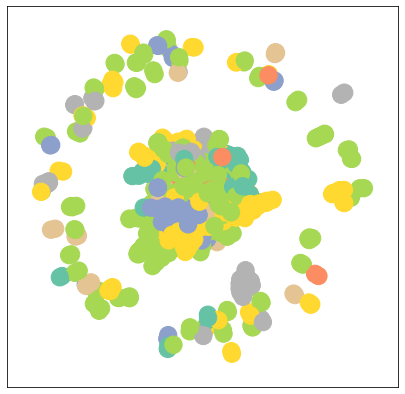

In [143]:
G = to_networkx(data, to_undirected = data.is_undirected())
visualize_graph(G, data.y)

### **3) 신경망을 구성하고 학습해보자**
- torch_geometric에는 GCNConv, GCN2Conv 등 다양한 신경망들이 구현되어 있다.
- 내부코드를 들어가 확인해보니 Linear층 하나로만 구성되어 있었다.

In [144]:
from torch_geometric.nn import GCNConv
from torch.nn import Linear

In [145]:
class GeometricGCN(Module):

  def __init__(self):

    super(GeometricGCN, self).__init__()
    self.conv1 = GCNConv(dataset.num_node_features, 16)
    self.conv2 = GCNConv(16, dataset.num_classes)

  def forward(self, data):

    x, edge_idx = data.x, data.edge_index
    x = self.conv1(x, edge_idx).relu()
    x = F.dropout(x, p = DROP_OUT, training = self.training)
    x = self.conv2(x, edge_idx)

    return x


In [146]:
model     = GeometricGCN().to(device)
data      = dataset[0].to(device)
optimizer = optim.Adam(model.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)
loss_func = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


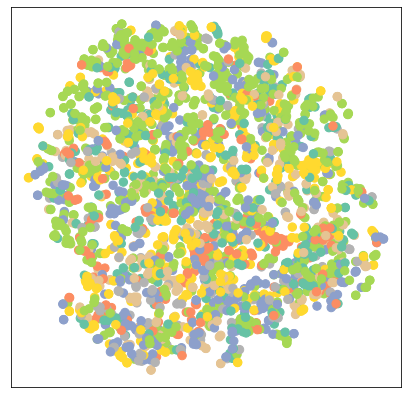

In [147]:
output = model(data)
visualize_embedding(output, data.y)

[Epoch: 1 / 1000]
 train loss : 1.946 | train accuracy : 0.150
 valid loss : 1.934 | valid accuracy: 0.174



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


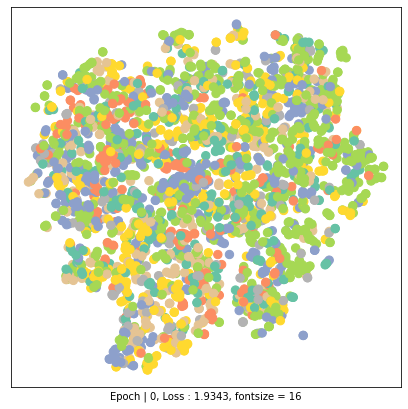

[Epoch: 101 / 1000]
 train loss : 0.031 | train accuracy : 1.000
 valid loss : 0.834 | valid accuracy: 0.744



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


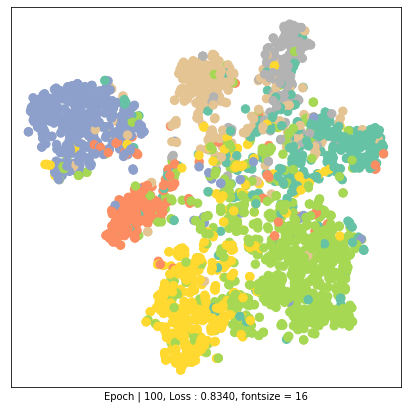

[Epoch: 201 / 1000]
 train loss : 0.026 | train accuracy : 1.000
 valid loss : 0.815 | valid accuracy: 0.770



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


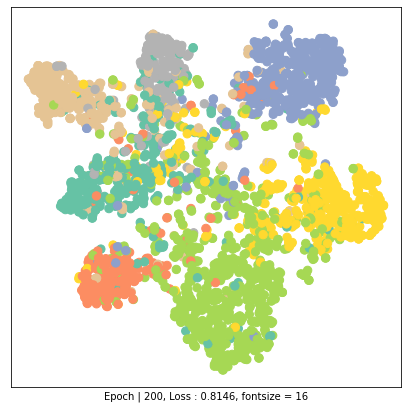

[Epoch: 301 / 1000]
 train loss : 0.017 | train accuracy : 1.000
 valid loss : 0.849 | valid accuracy: 0.748



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


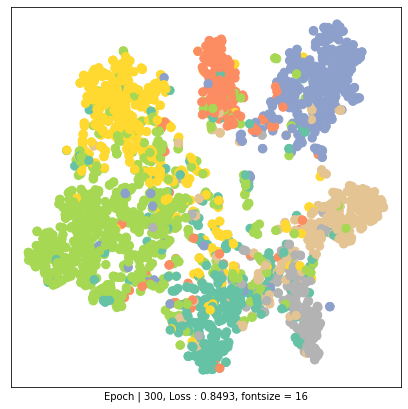

[Epoch: 401 / 1000]
 train loss : 0.014 | train accuracy : 1.000
 valid loss : 0.847 | valid accuracy: 0.760



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


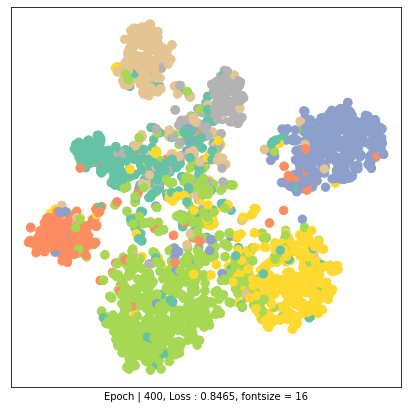

[Epoch: 501 / 1000]
 train loss : 0.010 | train accuracy : 1.000
 valid loss : 0.838 | valid accuracy: 0.754



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


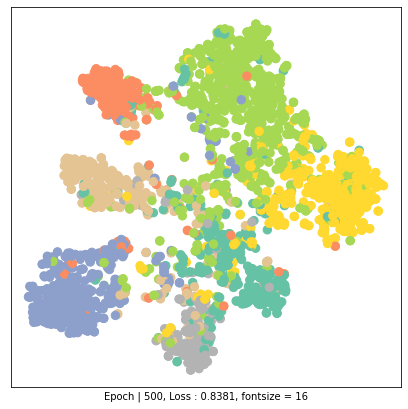

[Epoch: 601 / 1000]
 train loss : 0.010 | train accuracy : 1.000
 valid loss : 0.789 | valid accuracy: 0.760



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


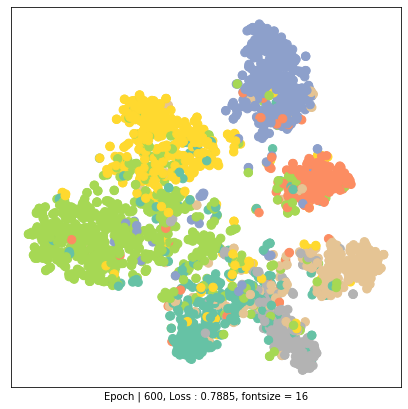

[Epoch: 701 / 1000]
 train loss : 0.015 | train accuracy : 1.000
 valid loss : 0.862 | valid accuracy: 0.756



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


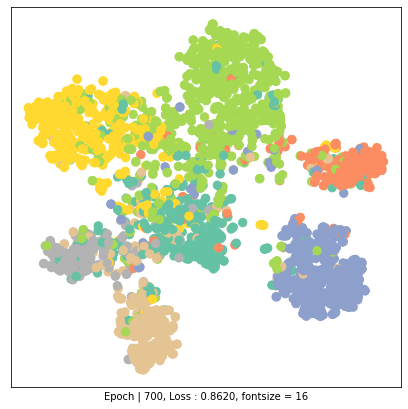

[Epoch: 801 / 1000]
 train loss : 0.011 | train accuracy : 1.000
 valid loss : 0.864 | valid accuracy: 0.770



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


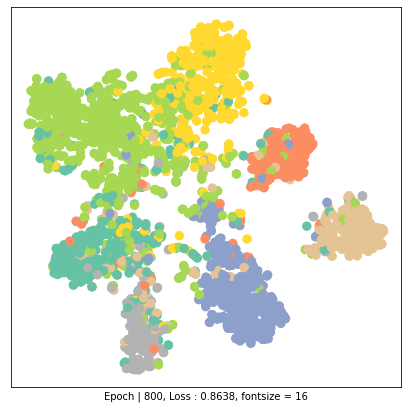

[Epoch: 901 / 1000]
 train loss : 0.010 | train accuracy : 1.000
 valid loss : 0.906 | valid accuracy: 0.732



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


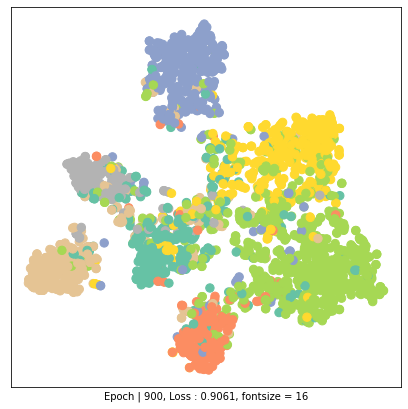

[Epoch: 1000 / 1000]
 train loss : 0.013 | train accuracy : 1.000
 valid loss : 0.883 | valid accuracy: 0.754



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


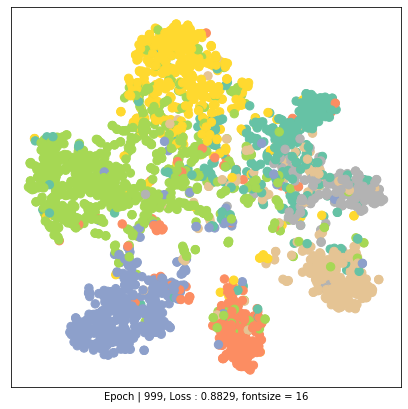

In [149]:
model.train()
for epoch in range(EPOCHS):

  optimizer.zero_grad()
  out = model(data)

  train_loss = loss_func(out[data.train_mask], data.y[data.train_mask])
  train_acc  = Utils.accuracy(out[data.train_mask], data.y[data.train_mask])

  train_loss.backward()
  optimizer.step() 

  val_loss = loss_func(out[data.val_mask], data.y[data.val_mask])
  val_acc  = Utils.accuracy(out[data.val_mask], data.y[data.val_mask])

  if (epoch % 100 == 0) or (epoch == EPOCHS - 1):
    print(f'[Epoch: {epoch + 1} / {EPOCHS}]\n',
      f'train loss : {train_loss.item():.3f} | train accuracy : {train_acc.item():.3f}\n',
      f'valid loss : {val_loss.item():.3f} | valid accuracy: {val_acc.item():.3f}\n')
    
    visualize_embedding(out, color = data.y, epoch = epoch, loss = val_loss)

test loss : 0.708 | test accuracy : 0.794



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


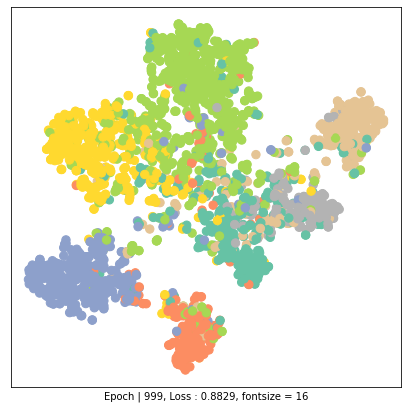

In [150]:
test_loss = loss_func(out[data.test_mask], data.y[data.test_mask])
test_acc  = Utils.accuracy(out[data.test_mask], data.y[data.test_mask])

print(f'test loss : {test_loss.item():.3f} | test accuracy : {test_acc.item():.3f}\n')

visualize_embedding(out, color = data.y, epoch = epoch, loss = val_loss)